In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch

from model import thalamocorticol_expansion as TCE

## some prep for the test images

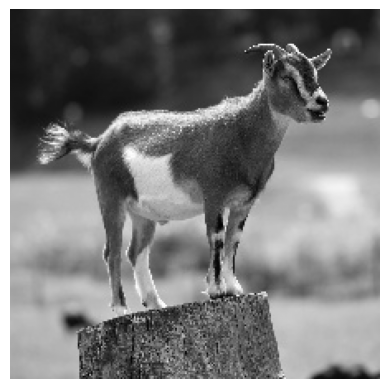

In [2]:
test_img = cv2.imread("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/test_images/goat.jpg", 0)
plt.imshow(test_img, cmap="gray")
plt.axis("off")
plt.show()

In [3]:
test_img.shape

(224, 224)

In [5]:
model = TCE(input_dim=(224,224), lgn_dim=(16,16), v1_dim=1024, device="cpu")
img_tensor = torch.Tensor(test_img / 255.)
x_lgn, x_v1 = model(img_tensor)

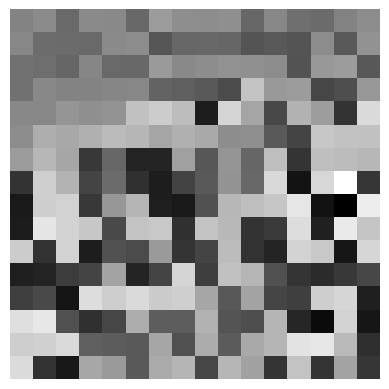

In [7]:
plt.imshow(x_lgn, cmap="gray")
plt.axis("off")
plt.show()

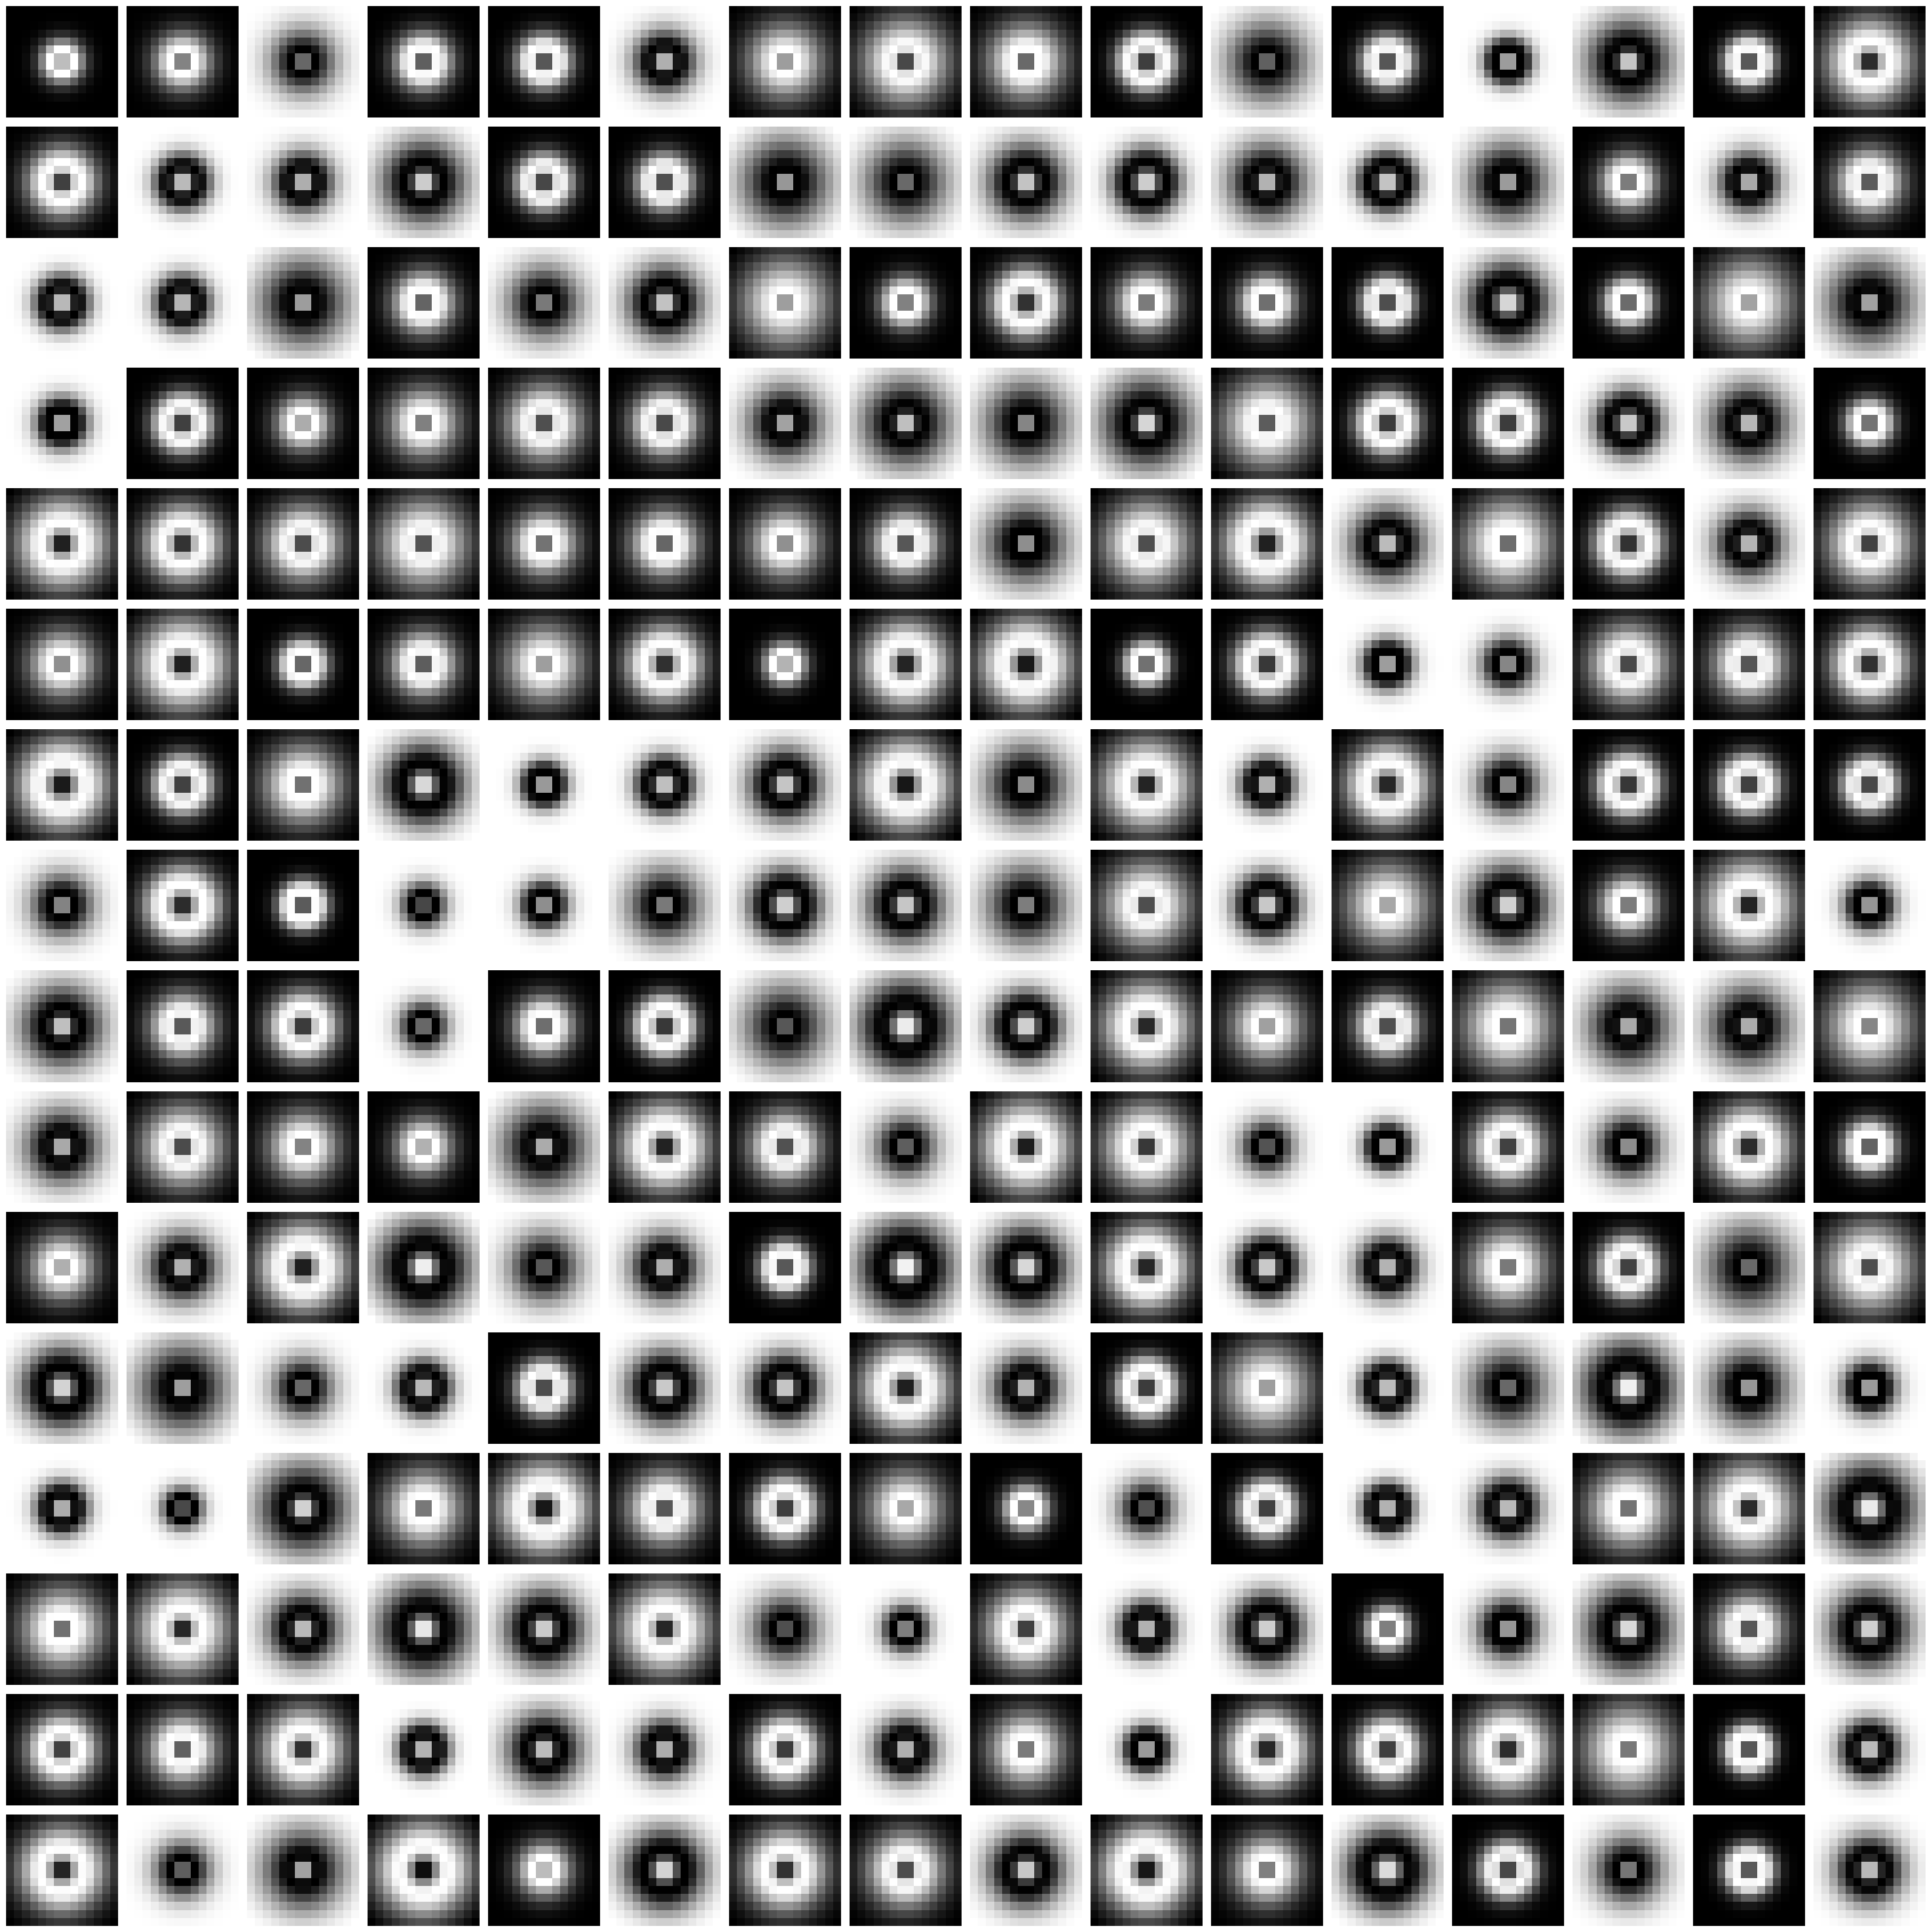

In [8]:
fig, ax = plt.subplots(16, 16, figsize=(32, 32))

# plot a few kernels
for i in range(16):
    for j in range(16):
        ax[i, j].imshow(model.lgn.kernels[i*16 + j], cmap="gray") #, vmin=-1, vmax=1)
        ax[i, j].axis("off")

fig.set_tight_layout(True)
plt.show()

In [9]:
x_v1.shape

torch.Size([1024])

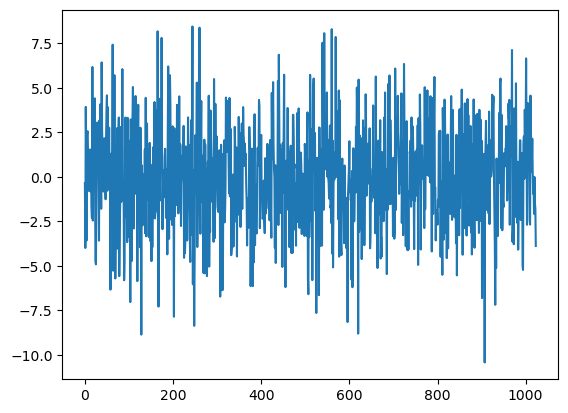

In [11]:
plt.plot(x_v1.detach().numpy())
plt.show()

In [3]:
# resize the test images so they are consistent
import glob

image_files = glob.glob("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/test_images/*.jpg")
for f in image_files:
    img = cv2.imread(f)
    img_resized = cv2.resize(img, (224, 224))
    cv2.imwrite(f, img_resized)

## testing whether RGC-LGN produces gaussian features

In [3]:
# okay, i'd like to check if the RGC2LGN model properly produces a set of gaussian features
import torch 
import glob

test_imgs = [torch.Tensor(cv2.imread(f).T) for f in glob.glob("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/test_images/*.jpg")]
print(f"Loaded {len(test_imgs)} test images.")
print(f"Each image has shape: {test_imgs[0].shape}") # should be (3, 224, 224)

R2L = RGC2LGN(sigmas=(0.8, 1.6, 3.2, 6.4, 12.8), kernel_size=None, channels=3)
lgn_rep = R2L(torch.stack(test_imgs)) # add batch dim
print(f"Output shape is {lgn_rep.shape}") # should be (5, 3 * 5 = 15) since 5 images, 3 channels * 5 sigmas

Loaded 5 test images.
Each image has shape: torch.Size([3, 224, 224])
Output shape is torch.Size([5, 15])


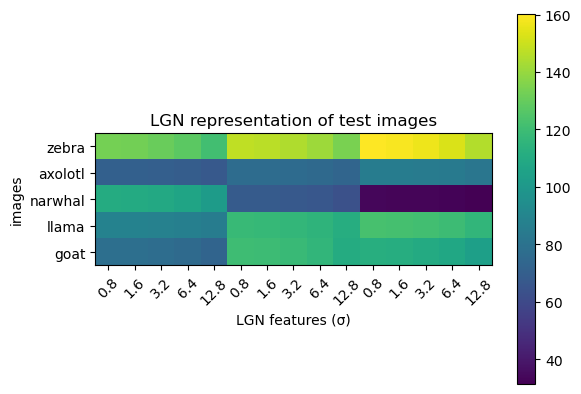

In [12]:
lgn_out_np = lgn_rep.detach().numpy()

plt.imshow(lgn_out_np, cmap='viridis')
plt.title("LGN representation of test images")
plt.ylabel("images")
plt.yticks(ticks=np.arange(len(test_imgs)), labels=[f.split("/")[-1].split(".")[0] for f in glob.glob("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/test_images/*.jpg")])
plt.xlabel("LGN features (σ)")
plt.xticks(ticks=np.arange(lgn_out_np.shape[1]), labels=[f"{sigma:.1f}" for sigma in [0.8, 1.6, 3.2, 6.4, 12.8] * 3], rotation=45)
plt.colorbar()
plt.show()

In [22]:
from utils import Utils as u
triplets, labels = u.load_mat("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/digits/triplet_digits_2.mat", mat_key="triplets")

In [31]:
labels[0][69775]

np.uint8(2)

## loading data

In [ ]:
# let's load the training data to a train/val/test torch datasets/loaders
from train import TripletDataset

np.random.seed(1234)
triplets = u.load_mat(
                      "/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/natural_movies/triplet_patches.mat", 
                      mat_key="allPatches") # triplets, labels = u.load_mat(args.data, mat_key=args.data_key)
indices = np.random.permutation(len(triplets))
train_size, val_size = int(0.7 * len(triplets)), int(0.1 * len(triplets))
train_data = TripletDataset(triplets[indices[:train_size]])
val_data = TripletDataset(triplets[indices[train_size:train_size + val_size]])
test_data = TripletDataset(triplets[indices[train_size + val_size:]])
print("training datasets properly loaded...")

print(triplets.shape)

## Testing non-decreasing loss function

In [1]:
import pickle
import matplotlib.pyplot as plt

In [5]:
filename = "/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M0p1_V1256_EP200.pkl"
with open(filename, 'rb') as f:
    metrics = pickle.load(f)
metrics.keys()

dict_keys(['train_losses', 'val_losses', 'train_triplet_losses', 'val_triplet_losses', 'train_l1_norms', 'val_l1_norms', 'train_viol', 'val_viol', 'train_time', 'best_epoch'])

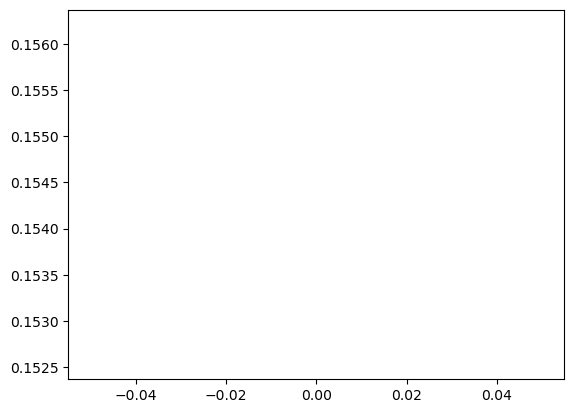

In [6]:
plt.plot(metrics["train_losses"], "k--")
plt.plot(metrics["val_losses"], "b--")
plt.show()

In [7]:
metrics["train_losses"]

[0.1561880044543765, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]